<a href="https://colab.research.google.com/github/gltmkm506/gltmkm506.github.io/blob/main/Networks_in_Story_of_the_Stone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Networks in *Story of the Stone*
This notebook is a tool that was made to visualize character networks based on interactions within *Story of the Stone*.



---

Below, you will be able to analyze the whole novel as a .txt file in your Google Drive, as well as the content of individual chapters. You MUST have your own .txt file in your Drive prior to proceeding. The code was generally inspired by my own work in David Bamman's 2020 iteration of INFO190 and work from vatsal220 on GitHub.

In [ ]:
import requests
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from collections import Counter
import operator

from pylab import rcParams
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import defaultdict
sns.set()

stop = stopwords.words('english')


book = "/content/drive/MyDrive/David Hawkes_Story of the Stone online version search copy.txt" #edit this to suit your personal .txt file and path in Drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
file = open(book, encoding='utf8')
chapter_start_locs=[0]
lines = file.readlines()

def chapter_segmentation(lines): #adapted from work by lucdar on GitHub
    chapter_start_locs = [0]
    chapter_names = ["PROLOGUE"]
    for idx in range(len(lines)):
        if "CHAPTER" in lines[idx]:
            chapter_start_locs.append(idx)
            chapter_names.append(lines[idx])
    return chapter_start_locs, chapter_names

def split_lines(lines, split_locs):
    output = []
    for i in range(1, len(split_locs)):
        start = split_locs[i-1]
        end = split_locs[i] - 1 # Marks the start of a new chapter
        output.append(lines[start:end])
    return output

def write_chapter_files(chapter_split_lines, chapter_names, ENABLE=False):
    if ENABLE == False:
        print("Skipped writing files. Your drive is safe (for now).")
        return
    for i in range(len(chapter_split_lines)):
        chapter_file = open("/content/drive/MyDrive/StoryOfTheStone_" + chapter_names[i].strip() + ".txt", "w") #Edit the filepath here to store chapters elsewhere.
        for line in chapter_split_lines[i]:
            chapter_file.write(line)
        chapter_file.close()

chapter_divisions, chapter_names = chapter_segmentation(lines)
output = split_lines(lines, chapter_divisions)
write_chapter_files(output, chapter_names) # add ENABLE=True to call to write the files again.


Skipped writing files. Your drive is safe (for now).


In [ ]:
#name dictionary
#Credit to Minford's translation of Story of the Stone for most of the name reference dictionary.
#Special characters have been omitted from the names for the program to parse cleaner text.
character_dict = {
 'Baoyu': ['Master Bao', 'Mr Bao'],
 'Baochai': ['Miss Xue', "Miss Bao", 'Chai', 'Cousin Chai'],
 'Oriole': [],
 'Parrot': [],
 'Daiyu': ['Miss Lin', 'Cousin Dai', 'Cousin Lin', 'Dai', 'Frowner'],
 'Aroma': [],
 'Ripple': [],
 'Ropey': [],
 'Shi Fu': [],
 'Silver': [],
 'Golden': [],
 'Grannie Liu': [],
 'Xichun': ['Cousin Xi'],
 'Tanchun': ['Cousin Tan'],
 'Yuanchun': ['Her Grace'],
 'Yingchun': ['Ying', 'Cousin Ying'],
 'Jingui': ['Miss Xia'],
 'Jia Zheng': ['Sir Zheng', 'Master Zheng'],
 'Li Wan': ['Cousin Wan', 'Mrs Zhu'],
 'Xifeng': ['Mrs Lian', 'Cousin Feng','Feng', 'Fengie'],
 'Keqing': ['Qinshi', 'Mrs Rong'],
 'Xiangyun': ['Cousin Shi', 'Cousin Yun', 'Miss Shi'],
 'Yucun': ['Jia Yucun'],
 'Tealeaf': [],
 'Impervioso': [],
 'Mysterioso': [],
 'Lady Wang': [],
 'Lady Xing': [],
 'Grandmother Jia': ['Her Ladyship', 'Lady Jia', 'Her Old Ladyship'],
 'Aunt Xue': ['Mrs Xue'],
 'Mrs You': [],
 'Mrs Zhang': [],
 'Qiaojie': [],
 'Qin Zhong': [],
 'Jia Lian': ['Mr Lian', 'Master Lian', 'Cousin Lian'],
 'Sanjie': [],
 'Erjie': [],
 'Xue Pan': ['Pan', 'Mr Pan', 'Cousin Pan', 'Cousin Xue'],
 'Xue Ke': ['Cousin Ke'],
 'Xiuyan': ['Miss Xing'],
 'Mongol Prince': [],
 'Mr Mei': [],
 'Cao Xueqin': [],
 'Skybright': [],
 'Caltrop': ['Xiangling'],
 'Patience': [],
 'Jia She': ['Master She', 'Sir She'],
 'Faithful': ['Faithiul'],
 'Nightingale': [],
 'Snowgoose': [],
 'Suncloud': [],
 'Sunset': [],
 'Sunshine': [],
 'Adamantina': [],
 'Perfecta': [],
 'Jia Zhen': ['Master Zhen', 'Cousin Zhen', 'Mr Zhen'],
 'Jia Lan': [],
 'Lady You': ['Youshi', 'Mrs Zhen'],
 'Jia Rong': ['Master Rong'],
 'Jia Huan': ['Master Huan', 'Huan'],
 'Musk': [],
 'Nannie Zhao': [],
 'Nannie Li': [],
 'Nannie Liu': [],
 'Nannie Wang': [],
 'Baoqin': ['Cousin Qin'],
 'Zixing': [],
 'Zhou Rui': [],
 'Mrs Zhou': [],
 'Jia Jing': ['Sir Jing'],
 'He San': [],
 'Lai Da': [],
 'Shangrong': [],
 'Lai Sheng': [],
 'Landscape': [],
 'Li Gui': [],
 'Li Qi': [],
 'Li Ten': [],
 'Li Xiao': [],
 'Li Wen': [],
 'Li Xiao': [],
 'Zhixiao': [],
 'Zisheng': [],
 'Lovey': [],
 'Master Zhou': [],
 'Cook Liu': [],
 'Fivey': [],
 'Parfume': ['Adventurin'],
 'Nenuphar': [],
 'Etamine': [],
 'Cardamome': [],
 'Aunt Zhao': ['Mrs Zhao'],
 'Aunt Zhou': [],
 'Althee': [],
 'Jia Qiang': ['Mr Qiang'],
 'Ziteng': [],
 'Zhen Baoyu': [],
 'Lady Zhen': [],
 'Moonbeam': [],
 'Disenchantment': [],
 'Vanitas': [],
 'Mother Ma': [],
 'Li Kui': [],
 'Pearl': [],
 'Jia Yun': ['Mr Yun'],
 'Bao Yong': [],
 'Bao Er': [],
 'Baner': [],
 'Bao Yin': [],
 'Big Jiao': [],
 'Bijou': ['Yuhan'],
 'Brightie': [],
 'Brighties wife': [],
 'Candida': [],
 'Casta': [],
 'Censor Li': [],
 'Crimson': [],
 'Dai Liang': [],
 'Dime': ['Ni Er'],
 'Dove': [],
 'Duke of AnGuo': [],
 'Dumbo': ['Xing Dequan'],
 'Felicity': [],
 'Amber': [],
 'Rixing': [],
 'Gaffer Li': [],
 'Halfimmortal Mao': [],
 'Hushi': [],
 'Hua Zifang': [],
 'Daihua': [],
 'Dairu': ['Preceptor'],
 'Jia Fan': [],
 'Jia Hua': [],
 'Jia Qin': ['Mr Qin'],
 'Jia Sijie': [],
 'Xiluan': [],
 'Jia Zhi': [],
 'Jia Zhu': [],
 'Sun Shaozu': ['Mr Sun'],
 'Mrs Li': [],
 'Mrs Xia': [],
 'Prince of Beijing': [],
 'Prince of Xiping': [],
 'Prosper': [],
 'Qinger': [],
 'Wang Ren': [],
 'Qiu Shian': [],
 'Wang Zhong': [],
 'Wu Gui': [],
 'Wu Liang': [],
 'Xia San': [],
 'Zhan Hui':[],
}

In [ ]:
#text preprocessing
#Capitalized characters were left to better identify names. Clean these if considering different approaches to visualizing networks.

def concat_names(txt, character_dict):
    space_names = list(filter(lambda x: " " in x, character_dict.keys()))
    output = txt
    for alias_list in character_dict.values():
        for alias in alias_list:
            if " " in alias:
                space_names.append(alias)
    for space_name in space_names:
        no_space_name = space_name.replace(" ", "")
        output = output.replace(space_name, no_space_name)
        # print("I'm replacing", space_name, "with", no_space_name)
    return output

def no_space_char_dict(char_dict):
    cleaned_keys = []
    cleaned_vals = []
    for name in list(char_dict.keys()):
        cleaned_keys += [name.replace(" ", "")]
    for alias_list in list(char_dict.values()):
        new_alias_list = []
        for alias in alias_list:
            new_alias_list += [alias.replace(" ", "")]
        cleaned_vals += [new_alias_list]
    return {cleaned_keys[i]: cleaned_vals[i] for i in range(len(cleaned_keys))}

def remove_punctuations(txt, punct = string.punctuation):
    return ''.join([c for c in txt if c not in punct])

def remove_stopwords(txt, sw = list(stop)):
    return ' '.join([w for w in txt.split() if w.lower() not in sw])

def clean_text(txt):
    txt = txt.replace('\n', ' ').replace('\r', ' ').replace('\'', '')
    txt = remove_punctuations(txt)
    txt = remove_stopwords(txt)
    txt = concat_names(txt, character_dict)
    return txt

##########
#To clean the whole book, use the code below.
##########

# with open(book, encoding='utf-8') as text_file: # WARNING: the resulting visualization may not be readable!
#     contents = text_file.read()
#     clean_book = clean_text(contents)


##########
#To clean a particular chapter, use the code below.
##########
cleaned_dict = no_space_char_dict(character_dict)

chapter_choice = "/content/drive/MyDrive/StoryOfTheStone_CHAPTER 109.txt" #change CHAPTER XX to whichever chapter number you are looking at.
with open(chapter_choice, encoding='utf-8') as text_file: #This cleans the text for one chapter.
    contents = text_file.read()
    clean_chapter = clean_text(contents)

The rest of this notebook will create nodes that represent characters and edges between them weighted by the strength of their connection. This connection is defined by how often they are mentioned together within some window of words to represent interaction.

"Identifying these kinds of implicit networks allows us to visualize the connections within them, and also determine the structural properties of the characters within the network topology (such as degree centrality, betweenness centrality and closeness centrality)." (Bamman, 2020)

##Character Interactions in Chapter 109 of *Story of the Stone*
In the cell above, I have chosen to analyze Chapter 109. Through this exercise, I will compare the judgement proposed by this quantitative approach to my own human summarization of the chapter.

In [ ]:
#Adapted from https://gist.github.com/vatsal220/983add2a4c604e01ce09cd85db5baf1d#file-create_character_network-py
N = 15 #width of search window
text = clean_chapter

def append__dct(character_dict):
    '''
    The purpose of this function is to add the key into the list of values
    as a lowered key
    '''
    if type(character_dict) == list:
        character_dict = {k:[k] for k in character_dict}

    character_dict_full = character_dict.copy()
    for k,v in character_dict_full.items():
        if k not in v:
            v.append(k)
    return character_dict_full

found_names_full = append__dct(cleaned_dict)

def generate_idx_dict(text, found_names_full):
    '''
    create an idx_dct where the keys are the idx of the names in
    the text and the values are the names
    '''
    res = dict()
    for i,word in enumerate(text.split(' ')):
        for k,v in found_names_full.items():
            if word not in v:
                continue
            res[i] = k
    return res
idx_dct = generate_idx_dict(text, found_names_full)

def find_interactions(idx_dct, N):
    res = defaultdict(int)
    names = list(idx_dct.keys())

    for i,na in enumerate(names):
        # given an index, get the sublist of all indicies greater than the current index
        if i < len(names) - 1:
            kl = names[i+1:]
        else:
            kl = []

        # for each idx greater than the current, check if its found in the range of N
        for k in kl:
            if k-na < N:
                # get names found in current position (na) and index greater than current but in range N (k)
                n1 = idx_dct[na]
                n2 = idx_dct[k]

                key = tuple(sorted([n1,n2]))
                res[key]+=1
    return res
interactions_dct = find_interactions(idx_dct, N)
interactions_lst = list([(*k,v) for (k,v) in interactions_dct.items()])

Graph with 29 nodes and 118 edges


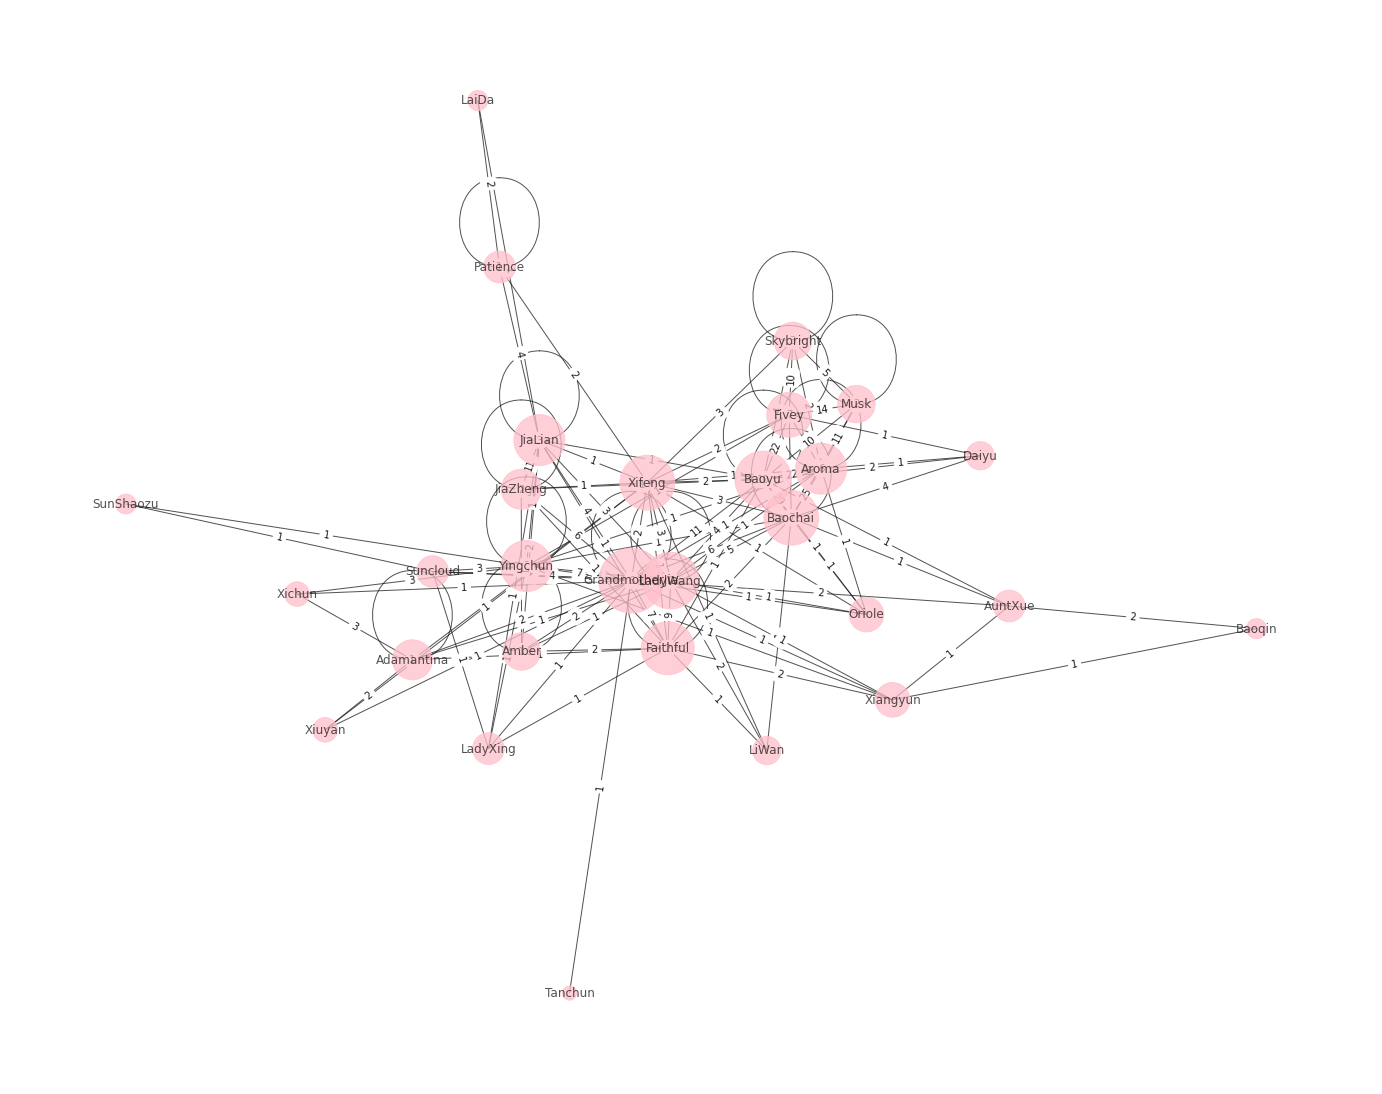

In [ ]:
# Code adapted from https://gist.github.com/vatsal220/08ef280d71ec1494a8f60eb601cfb785#file-find_interactions-py
edges_df = pd.DataFrame(interactions_lst, columns = ['source', 'target', 'weight'])
G = nx.from_pandas_edgelist(edges_df, edge_attr = True)
print(nx.info(G))

# size of viewing window
rcParams['figure.figsize'] = 19, 15
# pos = nx.circular_layout(G, scale = 20) #round map
labels = nx.get_edge_attributes(G, 'weight')

pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()), seed=219) #The algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close.
d = dict(G.degree)
nx.draw(
    G,
    pos,
    node_color='pink',
    alpha = 0.75,
    with_labels=True,
    nodelist=list(d.keys()),
    node_size=[d[k]*200 for k in d],
    edgelist = list(labels.keys())
)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

##########
#If you want to see the amount of times the most prevalent characters appear in bar graphs.
##########

# pr = nx.pagerank(G)
# pr = {k: v for k, v in sorted(pr.items(), reverse = True, key=lambda item: item[1])}
# pr_df = pd.DataFrame([pr]).T.reset_index().rename(columns = {0 : 'pr', 'index' : 'name'})

# # visualize page rank to see character prevalence
# plt.barh(y = pr_df['name'].head(10), width = pr_df['pr'].head(10))
# plt.title("Page Rank of Story of the Stone Chapter Characters")
# plt.ylabel("Characters")
# plt.xlabel("Page Rank Score")
# plt.show()

Chapter 109 opens with the following couplet:
>Fivey shares a vigil, and receives
affection meant for another
<br>
>Ying-chun pays her debt to fate, and returns
to the Realm of Primordial Truth

Referring to the network graph validates the greater attention that Fivey is given in the couplet, along with the person referred to as "another": Skybright. In this chapter, Bao-yu "remembered how Xi-feng had once likened Fivey to Skybright - ‘the spitting image’ had been her words," (Cao and Gao, tr. Minford, 1986). Interestingly, the spring layout algorithm draws a slightly greater distance between Bao-yu and Skybright, however, they remain closely related. Fivey is physically present in the scene, but as the couplet expresses as well, is put into Bao-yu's circle of maids as a stand-in for the late Skybright.

I believe the network's representation of Ying-chun is also supported by the summarizing couplet. Her experience is very removed from the scenes of Bao-yu in his chamber with all of his maids and wife. In her arc contained within the chapter, she grieves for her isolation from the family, and passes away in the same situation. However, her prevalence according to the network (node size) is weighted only as much as most other characters that tend to Bao-yu more closely, and much less than Grandmother Jia.

Against the tone set by the introductory couplet, it is very interesting that Grandmother Jia is such a central character here, although preparations for her death are made in this chapter. Why is this concluding event not alluded to? Is it for dramatic effect, and is this kind of structure present in other chapters? I think we can see a general attention to the structure of the Jia family as a whole here. Grandmother Jia and Lady Wang have a close connection, with Xi-feng closely hovering. Their roles in the family are major and in high status, and I think this graph reflects that with their combined central nature. Bao-yu has a system of his own, and maids stick closely with their masters/mistresses.

I think the effect of this exercise is one that refreshes the memory of the reader, and maybe serves as an effective chapter summary. Character interactions are a primary facet of this novel. Allusions to character relationships and their fates in context of the social network created by the novel are reinforced often. With the size of this novel and the great amount of characters, it can be useful to concisely visualize character networks to assess connections more comprehensively.

While not present in this notebook at the moment, it is possible to use this code to view and compare networks for every chapter of the novel. I believe executing a comprehensive review like this could prompt close analysis of different "systems" as I would call them -- sub-networks that center around side characters. For example, future work could analyze the connections around Faithful in each chapter, read into these exchanges, and see how something like hierarchical relationships manifest themselves in Faithful's social network.








##Supplementary Work

Below are some more explorations of the text that might inspire future work.

In [ ]:
#This code will not work for this notebook, but is a better explanation of what is going on in the cells above. Credit to Bamman 2020.

# def create_graph(nodes, edges, min_edge_weight=5):

#     G = nx.Graph()
#     for person in nodes:
#         G.add_node(person, nodesize=nodes[person])
#     for person1 in edges:
#         for person2 in edges[person1]:
#             if person1 in nodes and person2 in nodes and edges[person1][person2] > min_edge_weight:
#                 G.add_weighted_edges_from([(person1, person2, edges[person1][person2]) ])
#     return G


In [ ]:
# G=create_graph(nodes, edges)

In [ ]:
# def display_graph(G):

#     """ Plot a set of weighted nodes and weighted edges on a network graph """

#     # increase this to expand network
#     force_directed_expansion=10

#     # increase these dimensions to make graph bigger
#     figure_height=20
#     figure_width=20



#     options = {
#     'edgecolors':"black",
#     'linewidths':1,
#     'with_labels': True,
#     'font_weight': 'regular',
#     }

#     g_edges = G.edges()

#     sizes = [G.nodes[node]['nodesize'] for node in G]
#     weights = [G[u][v]['weight']/100. for u,v in g_edges]

#     fig, ax = plt.subplots(1, 1, figsize=(figure_height, figure_width));

#     nx.draw_networkx(G, pos=nx.spring_layout(G, k=force_directed_expansion, iterations=100), node_size=sizes, width=weights, **options)


In [ ]:
# display_graph(G)

In [ ]:
def print_top(measure, n=5):
    sorted_measure = sorted(measure.items(), key=operator.itemgetter(1), reverse=True)
    for node, val in sorted_measure[:5]:
        print("%s\t%.3f" % (node, val))

In [ ]:
centrality=nx.degree_centrality(G) #Here, we look at what NetworkX weighs as network centrality. Again, against the tone set by the introductory couplet for Chapter 109,
                                   #Grandmother Jia is the most central character! Fivey and Ying-chun are not here at all.
print_top(centrality, n=5)

GrandmotherJia	0.750
Baoyu	0.571
LadyWang	0.571
Baochai	0.536
Xifeng	0.536


In [ ]:
betweenness_centrality=nx.betweenness_centrality(G)
print_top(betweenness_centrality, n=5)

GrandmotherJia	0.251
Xifeng	0.118
Yingchun	0.108
JiaLian	0.103
Baoyu	0.093


In [ ]:
closeness_centrality=nx.closeness_centrality(G)
print_top(closeness_centrality, n=5)

GrandmotherJia	0.757
LadyWang	0.667
Baoyu	0.651
Xifeng	0.651
Baochai	0.636
